### Reconstruction of experimental nanoparticles using the Deep Image Prior approach

*This notebook presents the reconstruction of experimental nanoparticles using DIP approach. The method is applied on one sinogram, for different scenarios with various numbers of projections. The three acquisition scenarios are :*
- -60°:2°:+60°
- -60°:10°:+60°
- -30°:2°:+30°

#### The DIP formulation adapted to tomography consists of solving the following problem :

$$ \hat{\theta} = \underset{\theta}{\arg\min} \left\| P F_{\theta}(z) - y \right\|_2^2 $$

Where :
- $ F_{\theta} $ is the network and weights to optimized
- $ P $ is the forward operator (Radon transform)
- $ z $ is an input noise
- $ y $ are the acquired projections

*The method is applied to a 2D sinogram in order to reconstruct a 2D image.*

In [1]:
import sys
sys.path.insert(0, '../../Src')
from model import model_unet
from radon import Radon2D
from dip import dip_reconstruction
from utils import simplify, normalize

import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import torch

dtype = torch.cuda.FloatTensor
plt.rcParams['image.cmap'] = 'gray'

#### Load the experimental nanoparticles sinogram to reconstruct with deep image prior

The sinograms of interest are stored in *Data/Experimental* and corresponding angular range are placed in *Data/Angles*.
The acquisition scenario can be selected (1, 2 or 3) with **ACQUISITION_CASE**.
In this setup, no reference sinogram is available from comparison.
The SIRT reconstruction of the chosen sinogram is then computed.

In [2]:
# 1, 2 or 3 corresponding to acquisition range -60:2:+60, -60:10:+60 and -30:2:+30 respectively
ACQUISITION_CASE = 3

with open(f'../../Data/Angles/angles_{ACQUISITION_CASE}.txt') as file:
    ANGLE = np.array([int(line.strip()) for line in file])

degraded_sinogram = imread(f'../../Data/Experimental/experimental_{ACQUISITION_CASE}.tif')
degraded_sinogram = torch.from_numpy(degraded_sinogram).type(dtype)

IMG_SIZE = degraded_sinogram.shape[1]

radon_op = Radon2D(angle=np.deg2rad(ANGLE), size=IMG_SIZE)
sirt_degraded = radon_op.backward_sirt_ts(degraded_sinogram)
sirt_degraded = normalize(sirt_degraded)

Text(0.5, 1.0, 'Degraded sinogram (missing projections)')

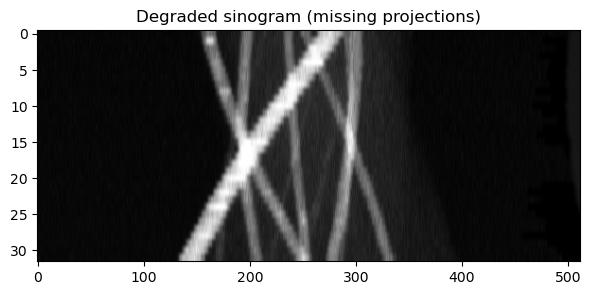

In [3]:
plt.figure(figsize = (7,3))
plt.imshow(simplify(degraded_sinogram), aspect='auto')
plt.title('Degraded sinogram (missing projections)')

#### Setup of the network and DIP parameters

The parameters are set with the values from the article.

- *NUM_ITER* : Number of training iterations (empirical choice)
- *LR* : optimization learning rate
- *INPUT_DEPTH* : Depth size of the input noise
- *STD_INP_NOISE* : Range of the input noise
- *NOISE_REG* : Per iteration regularization value on the input noise (from original DIP implementation (D. Ulyanov et al.))

For the DIP method :
- A possible TV weight can be added to add a TV regularization (*TV_WEIGHT*)

In [4]:
NUM_ITER = 1500
LR = 0.01
INPUT_DEPTH = 32
STD_INP_NOISE = 1./10. 
NOISE_REG = 1./30.
TV_WEIGHT = 0.0 # Optionnal

In [5]:
n_scale = 4
ud_filters = [16,32,64,128]
skip_filters = [4,8,16,32]
network = model_unet(input_shape=INPUT_DEPTH, output_shape=1,
                     down_filters=ud_filters, up_filters=ud_filters, skip_filters=skip_filters,
                     down_kernels=[3]*n_scale, up_kernels=[3]*n_scale, skip_kernels=[1]*n_scale,
                     up_mode='bilinear', down_mode='stride', pad_mode='zeros',
                     ).to('cuda').type(dtype)

  0%|          | 0/1500 [00:00<?, ?it/s]/nobackup/sb272614/Environments/env_tomo/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32, 512])) that is different to the input size (torch.Size([1, 1, 32, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


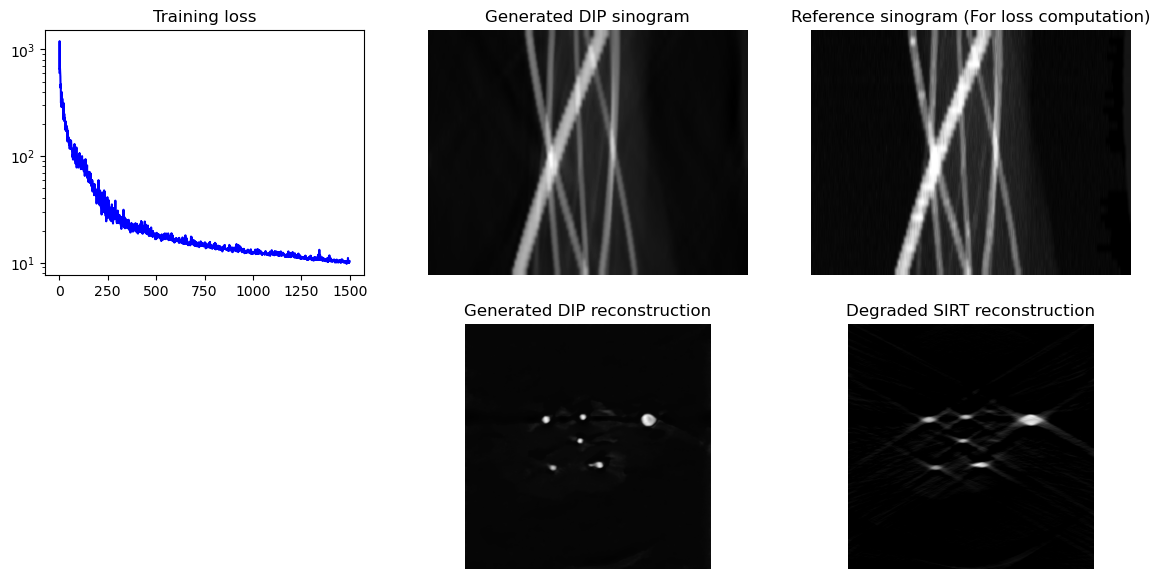

100%|██████████| 1500/1500 [00:43<00:00, 34.76it/s]


In [6]:
output = dip_reconstruction(NUM_ITER, LR, IMG_SIZE, STD_INP_NOISE, NOISE_REG,
                            np.flip(ANGLE), INPUT_DEPTH, network,
                            degraded_sinogram, sirt_degraded, DISPLAY=True,
                            tv_weight=0.0, tv_order=1)

best_loss   = output['best_loss']
best_output = output['best_output']
best_i      = output['best_i']
loss_values = output['loss_values']
net_trained = output['net']
best_input  = output['best_input']